In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization

In [2]:
# on average there are 252 trading days in a year
NUM_TRADING_DAYS = 252
# we will generate random w (different portfolios)
NUM_PORTFOLIOS = 10000

# stocks we are going to handle
stocks = ['AAPL', 'WMT', 'TSLA', 'GE', 'AMZN', 'DB','GS','JPM']


In [3]:
# historical data - define START and END dates
start_date = '2012-01-01'
end_date = '2022-01-01'


In [4]:
def download_data():
    # name of the stock (key) - stock values (2010-1017) as the values
    stock_data = {}

    for stock in stocks:
        # closing prices
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close']

    return pd.DataFrame(stock_data)

In [5]:
def show_data(data):
    data.plot(figsize=(10, 5))
    plt.show()

In [6]:
def calculate_return(data):
    # NORMALIZATION - to measure all variables in comparable metric
    log_return = np.log(data / data.shift(1))
    return log_return[1:]

In [7]:
def show_statistics(returns):
    # instead of daily metrics we are after annual metrics
    # mean of annual return
    print(returns.mean() * NUM_TRADING_DAYS)
    print(returns.cov() * NUM_TRADING_DAYS)

In [8]:
def show_mean_variance(returns, weights):
    # we are after the annual return
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov()
                                                            * NUM_TRADING_DAYS, weights)))
    print("Expected portfolio mean (return): ", portfolio_return)
    print("Expected portfolio volatility (standard deviation): ", portfolio_volatility)


In [9]:
def show_portfolios(returns, volatilities):
    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities, returns, c=returns / volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

In [10]:
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov()
                                                          * NUM_TRADING_DAYS, w))))

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)


In [11]:
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov()
                                                            * NUM_TRADING_DAYS, weights)))
    return np.array([portfolio_return, portfolio_volatility,
                     portfolio_return / portfolio_volatility])


In [12]:
# scipy optimize module can find the minimum of a given function
# the maximum of a f(x) is the minimum of -f(x)
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]


In [13]:
# what are the constraints? The sum of weights = 1 !!!
# f(x)=0 this is the function to minimize
def optimize_portfolio(weights, returns):
    # the sum of weights is 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # the weights can be 1 at most: 1 when 100% of money is invested into a single stock
    bounds = tuple((0, 1) for _ in range(len(stocks)))
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns
                                 , method='SLSQP', bounds=bounds, constraints=constraints)


In [14]:
def print_optimal_portfolio(optimum, returns):
    print("Optimal portfolio: ", optimum['x'].round(3))
    print("Expected return, volatility and Sharpe ratio: ",
          statistics(optimum['x'].round(3), returns))


In [15]:
def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(10, 6))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()

In [16]:
dataset = download_data()

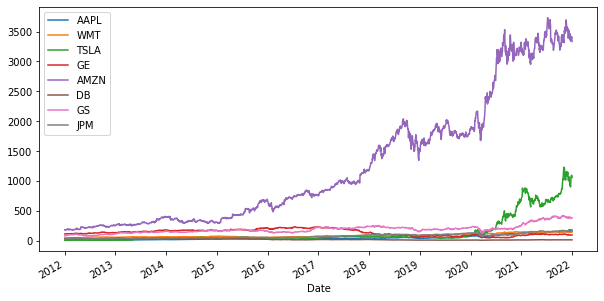

In [17]:
show_data(dataset)

In [18]:
log_daily_returns = calculate_return(dataset)

In [19]:
pweights, means, risks = generate_portfolios(log_daily_returns)

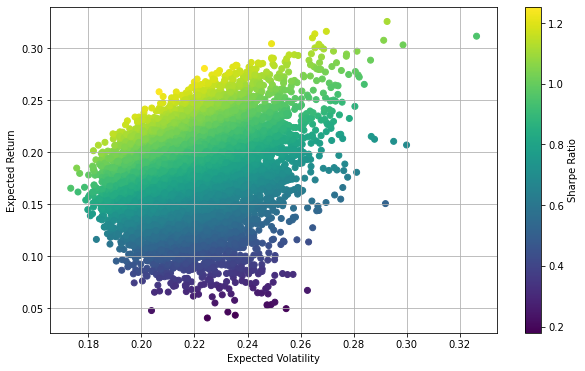

In [20]:
show_portfolios(means, risks)

In [21]:
optimum = optimize_portfolio(pweights, log_daily_returns)

In [22]:
print_optimal_portfolio(optimum, log_daily_returns)

Optimal portfolio:  [0.229 0.181 0.178 0.    0.293 0.    0.    0.119]
Expected return, volatility and Sharpe ratio:  [0.28122041 0.21848738 1.28712425]


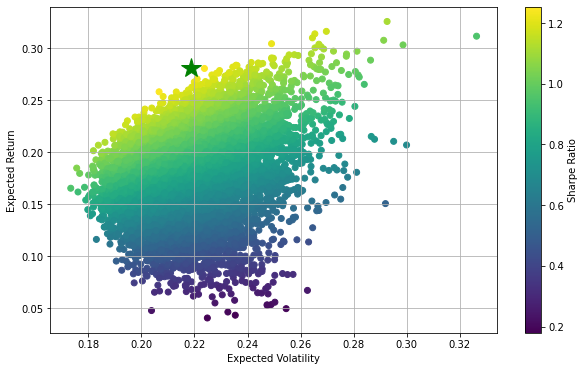

In [23]:
show_optimal_portfolio(optimum, log_daily_returns, means, risks)